In [1]:
"""
Section 1 Import Libraries
"""

import numpy as np
import cv2
import pickle
import glob
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

C:\Program Files\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
[WinError 5] Access is denied: 'C:\\Program Files\\Miniconda3\\envs\\carnd-term1\\lib\\site-packages\\imageio\\resources\\ffmpeg\\ffmpeg.win32.exe'
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



In [6]:
"""
Section 2 Define required functions
"""


def bin_spatial(image, size=(32, 32)):

    color1 = cv2.resize(image[:, :, 0], size).ravel()
    color2 = cv2.resize(image[:, :, 1], size).ravel()
    color3 = cv2.resize(image[:, :, 2], size).ravel()

    return np.hstack((color1, color2, color3))

def color_hist(img, nbins=32):

    color_1_hist = np.histogram(img[:, :, 0], bins=nbins)
    color_2_hist = np.histogram(img[:, :, 0], bins=nbins)
    color_3_hist = np.histogram(img[:, :, 0], bins=nbins)

    return np.concatenate((color_1_hist[0], color_2_hist[0], color_3_hist[0]))


def read_image(image):
    return mpimg.imread(image)

def extract_features(images, cspace='RGB', orient=9, spatial_size=(32, 32),
                     hist_bins=32, pix_per_cell=8, cell_per_block=2,
                     spatial_feat=True, hist_feat=True, hog_feat=True,
                     hog_channel=0):
    features = []
    
    # read image
    for image in images:
        file_features = []
        if type(image) == str:
            image = read_image(image)

        # Convert to color space
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat==True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat==True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)

        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel],
                                                     orient, pix_per_cell,
                                                     cell_per_block, vis=False,
                                                     feature_vec=True))
            hog_features = np.ravel(hog_features)
            file_features.append(hog_features)
        else:
            hog_features=get_hog_features(feature_image[:,:,hog_channel],orient,
                                          pix_per_cell, cell_per_block,
                                          vis=False, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return np.array(features)

def get_hog_features(img, orient, pix_per_cell,
                     cell_per_block, vis=False, feature_vec=True):
    if vis==True:
        features, hog_image = hog(img, orientations=orient,
                            pixels_per_cell=(pix_per_cell, pix_per_cell),
                            cells_per_block=(cell_per_block, cell_per_block),
                            transform_sqrt=False, visualise=True,
                            feature_vector=False)
        return features.ravel(), hog_image
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False, visualise=False,
                       feature_vector=feature_vec)
        return features.ravel()


# Set windows
x_start_stops = [[None,None],[None, None],[260, 1000]]
y_start_stops = [[420,650],[400,575],[375,500]]
xy_windows = [(240,150),(120,96),(60,48)]
xy_overlaps = [(0.75, 0.5),(0.75, 0.5),(0.75, 0.5)]


def slide_windows_list(img, x_start_stops=[None, None], y_start_stops=[None, None],
                 xy_windows=(64, 64), xy_overlaps=(0.5, 0.5)):

    windows = []
    for i in range(len(x_start_stops)):
        windows = slide_window(img, x_start_stops[i], y_start_stops[i],
                                xy_windows[i], xy_overlaps[i], windows)
    return windows

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5), window_list=[]):
    
    # if x and y start/stop positions == None, set to image size
    if x_start_stop[0] is None:
        x_start_stop[0] = 0
    if x_start_stop[1] is None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] is None:
        y_start_stop[0] = 0
    if y_start_stop[1] is None:
        y_start_stop[1] = img.shape[0]

    # Calculate the span of the search region 
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]

    # Calculate the number of pixels per step in the x and y direction
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))

    # Calculate the number of windows in x and y direction
    nx_windows = np.int(xspan / nx_pix_per_step) - 1
    ny_windows = np.int(yspan / ny_pix_per_step) - 1

    # Loop for searching x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to window_list array
            window_list.append(((startx, starty), (endx, endy)))

    # Return the list of windows
    return window_list

def search_windows(img, windows, clf, X_scaler, color_space, spatial_size,
                    hist_bins, orient, pix_per_cell, cell_per_block,
                    hog_channel, spatial_feat, hist_feat, hog_feat):

    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1],
                                  window[0][0]:window[1][0]], (64, 64))

        extracted_features = extract_features([test_img], cspace=color_space,
                                    orient=orient, spatial_size=spatial_size,
                                    hist_bins=hist_bins,
                                    pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    spatial_feat=spatial_feat,
                                    hist_feat=hog_feat, hog_feat=hist_feat,
                                    hog_channel=hog_channel)

        test_features=X_scaler.transform(np.array(extracted_features).reshape(1,
                                                                            -1))
        prediction = clf.predict(test_features)

        if prediction == 1:
            on_windows.append(window)

    return on_windows

def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Increment 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap # Return updated heatmap

def apply_threshold(heatmap, threshold):
    # All pixels below the threshold set to zero
    heatmap[heatmap <= threshold] = 0
    # Return thresholded heatmap
    return heatmap

def draw_box(img, labels):
    # Iterate through all positive detections
    for car_positive in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_positive).nonzero()

        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Define a bounding box and draw box
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0, 255, 255), 3)

    return img


class VehicleDetector:
    #Modified from the line class as detailed in the P4 lectures
    def __init__(self, color_space, orient, pix_per_cell, cell_per_block,
                 hog_channel, spatial_size, hist_bins, spatial_feat, hist_feat,
                 hog_feat, y_start_stops, x_start_stops, xy_windows,
                 xy_overlaps, heat_threshold, X_scaler, clf, max_queue_len):

        self.color_space = color_space
        self.orient = orient
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.y_start_stops = y_start_stops
        self.x_start_stops = x_start_stops
        self.xy_windows = xy_windows
        self.xy_overlaps = xy_overlaps
        self.X_scaler = X_scaler
        self.clf = clf
        self.heat_threshold = heat_threshold
        self.frames = []
        self.max_queue_len = max_queue_len
        self.first_frame = True
        self.slided_window = []

    def scan(self, input_image):
        if type(input_image) == str:
            input_image = read_image(input_image)

        copy_image = np.copy(input_image).astype(np.float32)/255

        if self.first_frame:
            self.slided_windows = slide_windows_list(copy_image,
                                x_start_stops=self.x_start_stops,
                                y_start_stops=self.y_start_stops,
                                xy_windows=self.xy_windows,
                                xy_overlaps=self.xy_overlaps)
            self.first_frame = False

        on_windows = search_windows(copy_image, self.slided_windows,
                            self.clf, self.X_scaler,
                            color_space=self.color_space,
                            spatial_size=self.spatial_size,
                            hist_bins=self.hist_bins, orient=self.orient,
                            pix_per_cell=self.pix_per_cell,
                            cell_per_block=self.cell_per_block,
                            hog_channel=self.hog_channel,
                            spatial_feat=self.spatial_feat,
                            hist_feat=self.hist_feat, hog_feat=self.hog_feat)

        heat_map = np.zeros_like(copy_image)
        heat_map = add_heat(heat_map, on_windows)
        self.frames.insert(0, heat_map)
        frames_stack = self.add_frames()
        heat_map = apply_threshold(frames_stack, self.heat_threshold)
        labels = label(heat_map)
        image_with_boxes = draw_box(input_image, labels)
        return image_with_boxes
    
    def add_frames(self):
        if len(self.frames) > self.max_queue_len:
            self.frames.pop()
        frames_stack = np.array(self.frames)
        return np.sum(frames_stack, 0)

In [ ]:
"""
Section 3 Learn car and notcar images with LinearSVC 
"""

print("Learning...")

# import images
cars = glob.glob("vehicles/*/*.png")
notcars = glob.glob("non-vehicles/*/*.png")
car_img = read_image(cars[0])
notcar_img = read_image(notcars[0])


# Set the parameters
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True


# Extract features from cars and notcars
car_features = extract_features(cars, color_space, orient,
                                      spatial_size, hist_bins, pix_per_cell,
                                      cell_per_block, spatial_feat, hist_feat,
                                      hog_feat, hog_channel)

notcar_features = extract_features(notcars, color_space, orient,
                                      spatial_size, hist_bins, pix_per_cell,
                                      cell_per_block, spatial_feat, hist_feat,
                                      hog_feat, hog_channel)


# Split data into training and test set 80:20 split
X_features = np.vstack((car_features, notcar_features)).astype(np.float64)
y_features = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))

X_train, X_test, y_train, y_test = train_test_split(X_features, y_features,
                                             test_size=0.2, random_state=50)
# Scale the features
X_scaler = StandardScaler().fit(X_features)

X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Train the Classifier using LinearSVC
svc = LinearSVC()
svc.fit(X_train, y_train)

# Show accuracy of the SVC
print('Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Calculate the prediction time taken for a single sample of 10
n_predictions = 10
print('SVC predicts: ', svc.predict(X_test[0:n_predictions]))
print('For these',n_predictions, 'labels: ', y_test[0:n_predictions])

# save parameters
params = {'color_space': color_space, 'orient': orient,
            'pix_per_cell': pix_per_cell, 'cell_per_block': cell_per_block,
            'hog_channel': hog_channel, 'spatial_size': spatial_size,
            'hist_bins': hist_bins, 'spatial_feat': spatial_feat,
            'hist_feat': hist_feat, 'hog_feat': hog_feat,
            'hog_channel': hog_channel, 'svc': svc, 'X_scaler': X_scaler}

with open('svc_pickled.p', 'wb') as handle:
    pickle.dump(params, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
print("Learning Completed")

In [7]:
"""
Section 4 Convert Video
"""

# Load parameters from pickle file
dist_pickle = pickle.load( open("svc_pickled.p", "rb" ) )
cell_per_block = dist_pickle["cell_per_block"]
pix_per_cell = dist_pickle["pix_per_cell"]
spatial_size = dist_pickle["spatial_size"]
spatial_feat = dist_pickle["spatial_feat"]
color_space = dist_pickle["color_space"]
hog_channel = dist_pickle["hog_channel"]
hist_bins = dist_pickle["hist_bins"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"]
X_scaler = dist_pickle["X_scaler"]
orient = dist_pickle["orient"]
svc = dist_pickle["svc"]

# Initialize Detector Instance
detector = VehicleDetector(color_space=color_space, orient=orient,
pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
hog_channel=hog_channel, spatial_size=spatial_size,
hist_bins=hist_bins, spatial_feat=spatial_feat, hist_feat=hist_feat,
hog_feat=hog_feat, y_start_stops=y_start_stops,
x_start_stops=x_start_stops, xy_windows=xy_windows,
xy_overlaps=xy_overlaps, heat_threshold=30, X_scaler=X_scaler,
clf=svc, max_queue_len=25)

# Convert Video
input_video = "./project_video.mp4"
output_video = "./project_video_for_submission.mp4"

clip = VideoFileClip(input_video)
out_clip = clip.fl_image(detector.scan)
out_clip.write_videofile(output_video, audio=False)


  self.nchannels))



KeyboardInterrupt: 

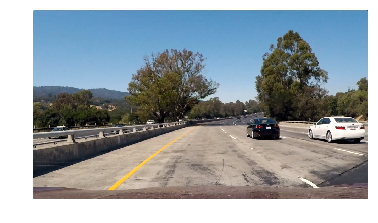

In [8]:
"""
Section 5 Test Visualizations for testing purposes
"""

for image in glob.glob("./test_images/*1.jpg"):
    img = mpimg.imread(image)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

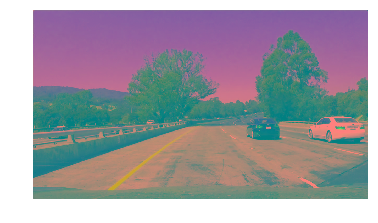

In [9]:
for image in glob.glob("./test_images/*1.jpg"):
    img = mpimg.imread(image)
    img= cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

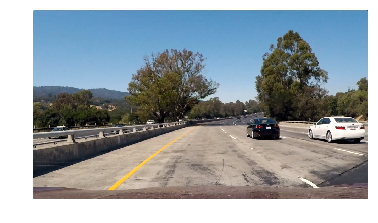

In [10]:
for image in glob.glob("./test_images/*1.jpg"):
    img = mpimg.imread(image)
    img= detector.scan(img)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread("test_images/test1.jpg")

# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[420,650], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.5))
                       
window_img = draw_boxes(image, windows, color=(255, 255, 255), thick=6) 

plt.imshow(window_img)
plt.grid(False, which='both')
plt.show()

windows2 = slide_window(window_img, x_start_stop=[None, None], y_start_stop=[400,575], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.5))
                       
window_img2 = draw_boxes(window_img, windows2, color=(0, 255, 255), thick=6) 

plt.imshow(window_img2)
plt.grid(False, which='both')
plt.show()

windows3 = slide_window(window_img2, x_start_stop=[260,1000], y_start_stop=[375,500], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.5))
                       
window_img3 = draw_boxes(window_img2, windows3, color=(0, 0, 255), thick=6) 

plt.imshow(window_img3)
plt.grid(False, which='both')
plt.show()